In [13]:
import pandas as pd
import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

import shap

In [14]:
df = pd.read_csv("./dataset/creditcard.csv")

In [15]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
df.shape

(284807, 31)

In [17]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [18]:
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

print(f"Shape of Fraudulant transactions: {fraud.shape}")
print(f"Shape of Non-Fraudulant transactions: {normal.shape}")

Shape of Fraudulant transactions: (492, 31)
Shape of Non-Fraudulant transactions: (284315, 31)


In [19]:
x = df.drop('Class', axis=1)
y = df.Class

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

start = time.time()
model = RandomForestClassifier()
model.fit(x_train, y_train)
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

Training time: 141180.61995506287ms


In [21]:
explainer = shap.TreeExplainer(model, feature_dependence="independent")
start = time.time()
print(start)
shap_values = explainer.shap_values(x_train)
stop = time.time()
print(stop)

print(f"Training time: {(stop - start) * 1000 }ms")

1621709533.695811


feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.


1621711123.46691
Training time: 1589771.0988521576ms


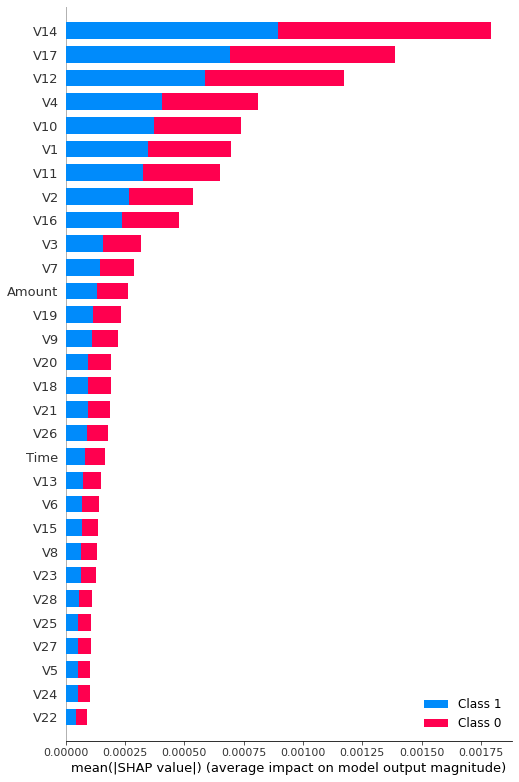

In [22]:
shap.initjs()

shap.summary_plot(shap_values, x_train, max_display=len(x.columns))

In [25]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(x_train.columns, sum(vals))),columns=['feature_name','importance_value'])
feature_importance.sort_values(by=['importance_value'],ascending=False,inplace=True)
feature_importance.to_csv('./results/random-forest/cc-fraud-shap-random-forest.csv')

print(feature_importance.to_latex())

\begin{tabular}{llr}
\toprule
{} & feature\_name &  importance\_value \\
\midrule
14 &          V14 &        178.540740 \\
17 &          V17 &        138.214021 \\
12 &          V12 &        116.735307 \\
4  &           V4 &         80.975493 \\
10 &          V10 &         73.854558 \\
1  &           V1 &         69.409760 \\
11 &          V11 &         64.872522 \\
2  &           V2 &         53.458866 \\
16 &          V16 &         47.702313 \\
3  &           V3 &         31.618076 \\
7  &           V7 &         28.742319 \\
29 &       Amount &         26.028112 \\
19 &          V19 &         23.369754 \\
9  &           V9 &         22.087690 \\
20 &          V20 &         19.178026 \\
18 &          V18 &         18.984821 \\
21 &          V21 &         18.598131 \\
26 &          V26 &         17.896018 \\
0  &         Time &         16.489262 \\
13 &          V13 &         15.010573 \\
6  &           V6 &         14.088459 \\
15 &          V15 &         13.587823 \\
8  &           V

In [26]:
import os

measures_data = []
featured_names = []

def print_classification_report(classification_report):
    accuracy = classification_report["accuracy"]
    precision = classification_report["weighted avg"]["precision"]
    f1_score = classification_report["weighted avg"]["f1-score"]
    recall = classification_report["weighted avg"]["recall"]
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1_score}")
    print(f"Recall: {recall}")
    print(f"Training time: {(stop - start) * 1000 }s")

def get_measures(feature, classification_report, training_time, shap_value, storage): 
    accuracy = classification_report["accuracy"]
    precision = classification_report["weighted avg"]["precision"]
    f1_score = classification_report["weighted avg"]["f1-score"]
    recall = classification_report["weighted avg"]["recall"]
    
    measures_data.append([feature, accuracy, precision, recall, f1_score, training_time, shap_value, storage])

def train_model(feature, shap_value):
    featured_names.append(feature)
    
    x = df[featured_names]
    y = df.Class
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

    start = time.time()
    model = RandomForestClassifier()
    model.fit(x_train, y_train)
    stop = time.time()
    
    prediction = model.predict(x_test)

    storage = get_storage(featured_names)
    training_time = (stop - start) * 1000
    classification = classification_report(y_test, prediction, output_dict=True)
    get_measures(feature, classification, training_time, shap_value, storage)

def get_storage(features):
    merged_features = ['Class'] + features
    temp = df[merged_features]
    temp.to_csv('./dataset/temp.csv')
    
    return os.stat('./dataset/temp.csv').st_size
            
def shap_all(df):
    for index, row in df.iterrows():
        train_model(row['feature_name'], row['importance_value'])

In [27]:
shap_all(feature_importance)

measures_df = pd.DataFrame(measures_data, columns = ['Feature Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time', 'Shap Value', 'Storage'])

measures_df.to_csv('./results/random-forest/cc-fraud-random-forest-report.csv')

In [28]:
measures_df.head()

,Feature Name,Accuracy,Precision,Recall,F1 Score,Training Time,Shap Value,Storage
0,V14,0.998432,0.998432,0.998432,0.998432,24457.803011,178.540740,7658695
1,V17,0.999321,0.999300,0.999321,0.999308,25377.820969,138.214021,12903467
2,V12,0.999403,0.999371,0.999403,0.999370,22176.786184,116.735307,18085667
3,V4,0.999520,0.999506,0.999520,0.999488,39399.821043,80.975493,23224833
4,V10,0.999532,0.999514,0.999532,0.999515,40989.783764,73.854558,28453052


In [32]:
import matplotlib.pyplot as plt

# Performance

def show_accuracy_chart(df):
    temp_1 = df['Accuracy'].tolist()
    temp_2 = list(range(1,(len(temp_1) + 1)))
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/random-forest/cc-fraud-random-forest-accuracy.png')

def show_precision_chart(df):
    temp_1 = df['Precision'].tolist()
    temp_2 = list(range(1,(len(temp_1) + 1)))
    plt.xlabel("Number of features")
    plt.ylabel("Precision (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/random-forest/cc-fraud-random-forest-precision.png')
    
def show_recall_chart(df):
    temp_1 = df['Recall'].tolist()
    temp_2 = list(range(1,(len(temp_1) + 1)))
    plt.xlabel("Number of features")
    plt.ylabel("Recall (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/random-forest/cc-fraud-random-forest-recall.png')
    
def show_f1_score_chart(df):
    temp_1 = df['F1 Score'].tolist()
    temp_2 = list(range(1,(len(temp_1) + 1)))
    plt.xlabel("Number of features")
    plt.ylabel("F1 Score (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/random-forest/cc-fraud-random-forest-f1-score.png')

# Storage
    
def show_storage_chart(df):
    temp_1 = df['Storage'].tolist()
    temp_2 = list(range(1,(len(temp_1) + 1)))
    plt.xlabel("Number of features")
    plt.ylabel("Storage (bytes)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/random-forest/cc-fraud-random-forest-storage.png')
    
# Training Time
    
def show_training_chart(df):
    temp_1 = df['Training Time'].tolist()
    temp_2 = list(range(1,(len(temp_1) + 1)))
    plt.xlabel("Number of features")
    plt.ylabel("Time (ms)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/random-forest/cc-fraud-random-forest-storage.png')

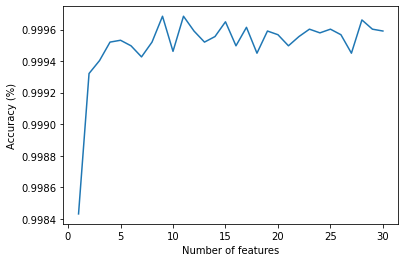

In [33]:
show_accuracy_chart(measures_df)

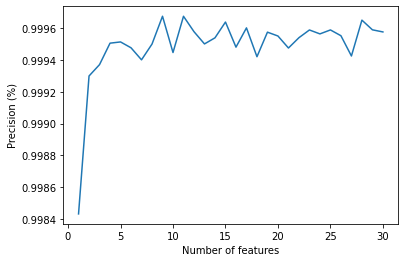

In [34]:
show_precision_chart(measures_df)

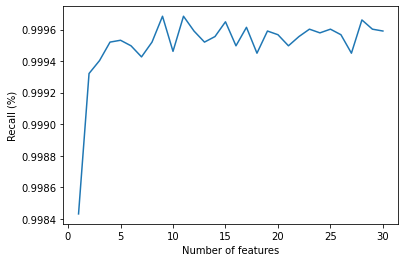

In [35]:
show_recall_chart(measures_df)

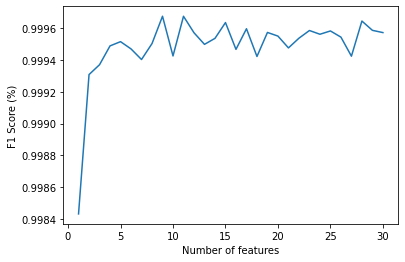

In [36]:
show_f1_score_chart(measures_df)

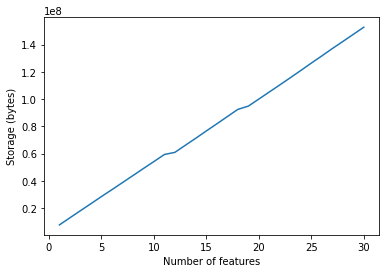

In [37]:
show_storage_chart(measures_df)

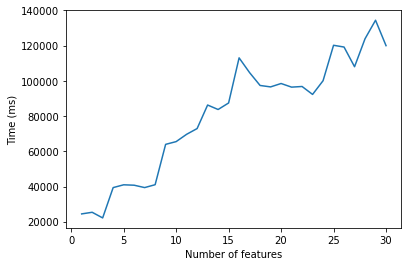

In [38]:
show_training_chart(measures_df)